This notebook is heavily inspired by https://www.kaggle.com/code/benjenkins96/march-mania-finding-the-signal-before-the-buzzer and https://www.kaggle.com/code/sanandachowdhury/ncaa-march-madness-sabermetric-spin-v2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
import optuna
import xgboost as xgb
from sklearn import ensemble
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2023/Conferences.csv
/kaggle/input/march-machine-learning-mania-2023/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2023/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2023/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2023/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2023/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2023/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2023/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2023/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-2023/Cities.csv
/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv
/kaggle/input/march-machine-learning-mania-2023/MTeamSpellings.csv
/k

**Data Section 1 file: MNCAATourneySeeds.csv and WNCAATourneySeeds.csv**

**Season** - the year that the tournament was played in

**Seed** - this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tell you the seed within the region. For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have seeds with the same first three characters. The "a" and "b" are assigned based on which Team ID is lower numerically. As an example of the format of the seed, the first record in the MNCAATourneySeeds file is seed W01 from 1985, which means we are looking at the #1 seed in the W region (which we can see from the "MSeasons.csv" file was the East region).

**TeamID** - this identifies the id number of the team, as specified in the MTeams.csv or WTeams.csv file

**We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 12, 2023 (DayNum=132).**

In [2]:
df_seeds = pd.concat([
    pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/MNCAATourneySeeds.csv"),
    pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
4093,2023,Z12,3405
4094,2023,Z13,3387
4095,2023,Z14,3241
4096,2023,Z15,3436


**Data Section 2 file: MRegularSeasonDetailedResults.csv and WRegularSeasonDetailedResults.csv**

These files provide team-level box scores for many regular seasons of historical data, starting with the 2003 season (men) or starting with the 2010 season (women). All games listed in the MRegularSeasonCompactResults file since the 2003 season should exactly be present in the MRegularSeasonDetailedResults file, and similarly, all games listed in the WRegularSeasonCompactResults file since the 2010 season should exactly be present in the WRegularSeasonDetailedResults file.

In [3]:
df_season_results = pd.concat([
    pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv"),
    pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2003,10,1104,68,1328,62,27,58,3,14,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,...,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,...,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,...,17,27,21,15,12,10,7,1,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178412,2023,132,3179,89,3125,71,31,53,9,22,...,2,6,11,17,14,8,6,2,16,18
178413,2023,132,3221,66,3131,61,23,44,4,12,...,11,16,6,13,7,6,11,3,20,5
178414,2023,132,3235,61,3400,51,20,59,7,17,...,6,14,19,26,13,14,5,12,19,10
178415,2023,132,3284,80,3406,55,26,51,7,18,...,5,7,10,16,8,15,6,2,20,25


# For each season / team, compute the Win Ratio and average score gap per game

In [4]:
# For every season and every team, count number of wins
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

# For every season and every team, count number of losses
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

# For every season and every team, count average score gap for games won
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

# For every season and every team, count average score gap for games lost
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})


In [5]:
# Merge all season feature dfs together 
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

# Fil NAs with 0's
df_features_season.fillna(0, inplace=True)  

df_features_season

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses
0,2003,1102,12.0,16.0,15.583333,11.250000
1,2003,1103,13.0,14.0,9.384615,7.500000
2,2003,1104,17.0,11.0,13.176471,9.454545
3,2003,1105,7.0,19.0,13.000000,11.473684
4,2003,1106,13.0,15.0,10.384615,9.266667
...,...,...,...,...,...,...
12130,2023,3473,1.0,24.0,9.000000,18.500000
12131,2023,3474,5.0,21.0,10.200000,20.523810
12132,2023,3475,9.0,17.0,13.000000,12.176471
12133,2023,3476,8.0,20.0,10.125000,12.800000


In [6]:
# Compute more intuitive team performance features using data thus far
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

df_features_season

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,WinRatio,GapAvg
0,2003,1102,12.0,16.0,15.583333,11.250000,0.428571,0.250000
1,2003,1103,13.0,14.0,9.384615,7.500000,0.481481,0.629630
2,2003,1104,17.0,11.0,13.176471,9.454545,0.607143,4.285714
3,2003,1105,7.0,19.0,13.000000,11.473684,0.269231,-4.884615
4,2003,1106,13.0,15.0,10.384615,9.266667,0.464286,-0.142857
...,...,...,...,...,...,...,...,...
12130,2023,3473,1.0,24.0,9.000000,18.500000,0.040000,-17.400000
12131,2023,3474,5.0,21.0,10.200000,20.523810,0.192308,-14.615385
12132,2023,3475,9.0,17.0,13.000000,12.176471,0.346154,-3.461538
12133,2023,3476,8.0,20.0,10.125000,12.800000,0.285714,-6.250000


# For each season / team, compute sabermetrics, elo, and Pythagorean W/L

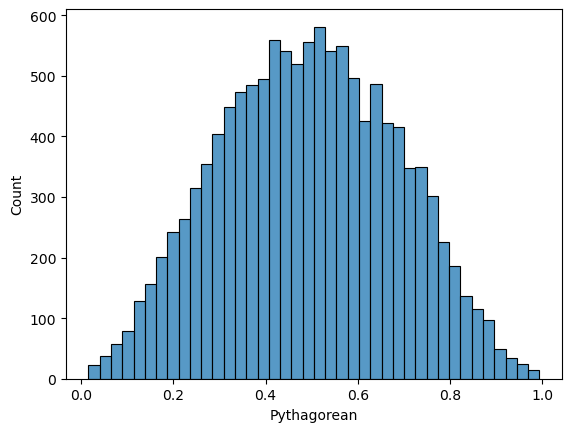

In [7]:
df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True) # Takes care of undefeated teams


df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] - 
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

win_points_scored = df_season_results.groupby(['Season', 'WTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "WPointsScored", "WTeamID": "TeamID"})
lose_points_scored = df_season_results.groupby(['Season', 'LTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "LPointsScored", "LTeamID": "TeamID"})

win_points_allowed = df_season_results.groupby(['Season', 'WTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "WPointsAllowed", "WTeamID": "TeamID"})
lose_points_allowed = df_season_results.groupby(['Season', 'LTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "LPointsAllowed", "LTeamID": "TeamID"})

total_points_scored = win_points_scored.merge(lose_points_scored, how='outer').fillna(0)
total_points_scored['PointsScored'] = total_points_scored['WPointsScored'] + total_points_scored['LPointsScored']

total_points_allowed = win_points_allowed.merge(lose_points_allowed, how='outer').fillna(0)
total_points_allowed['PointsAllowed'] = total_points_allowed['WPointsAllowed'] + total_points_allowed['LPointsAllowed']

# Pythagorean W/L
total_points = total_points_scored.merge(total_points_allowed, how='outer')
total_points['Pythagorean'] = 1 / (1 + (total_points['PointsAllowed'] / total_points['PointsScored']) ** 8)

# The 8 is arbitrary (KenPom I think uses 11.5). I wanted something that would create a nice bell shaped curve like below.
sns.histplot(total_points['Pythagorean'])
plt.show()




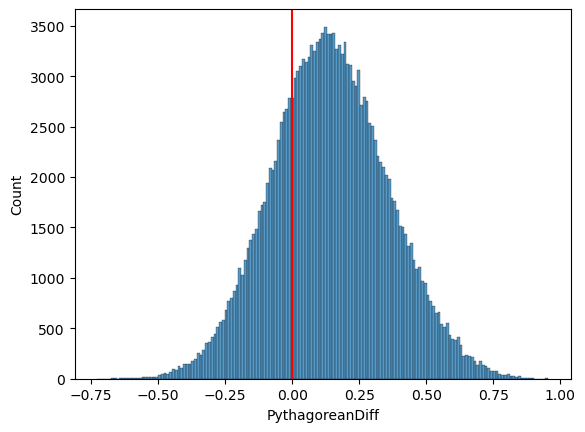

In [8]:
df_season_condensed = df_season_results[['Season', 'WTeamID', 'LTeamID']].copy()

df_season_condensed_pyth = df_season_condensed.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, "W"])
df_season_condensed_pyth = df_season_condensed_pyth.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, 'L'])
df_season_condensed_pyth['PythagoreanDiff'] = df_season_condensed_pyth['Pythagorean'] - df_season_condensed_pyth['PythagoreanL']

sns.histplot(df_season_condensed_pyth['PythagoreanDiff'])
plt.axvline(0, color='red')
plt.show()

In [9]:
sabermetrics = pd.DataFrame()
sabermetrics_differences = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']

sabermetrics_differences['Season'] = df_season_results['Season']
sabermetrics_differences['WTeamID'] = df_season_results['WTeamID']
sabermetrics_differences['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Rebound Percentage
sabermetrics['WReboundPct'] = (df_season_results['WDR'] + df_season_results['WOR']) / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LReboundPct'] = (df_season_results['LDR'] + df_season_results['LOR']) / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Steal Block Foul Ratio (the plus 1's are for getting rid of infinity and 0 bounds)
sabermetrics['WStealBlockFoul'] = (df_season_results['WStl'] + df_season_results['WBlk'] + 10) / (df_season_results['WPF'] + 10)
sabermetrics['LStealBlockFoul'] = (df_season_results['LStl'] + df_season_results['LBlk'] + 10) / (df_season_results['LPF'] + 10)

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']

# Free Throw Percentage
sabermetrics['WFTPct'] = df_season_results['WFTM'] / df_season_results['WFTA']
sabermetrics['LFTPct'] = df_season_results['LFTM'] / df_season_results['LFTA']

# Fill in missing values
sabermetrics['WStealBlockFoul'].fillna(df_season_results['WStl'] + df_season_results['WBlk'], inplace=True)
sabermetrics.fillna(0, inplace=True)



In [10]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]

winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)

weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""
        
    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df


combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

metrics_list = ['PtsPerPoss', 'EffectiveFGPct', 'AssistRate', 'ReboundPct', 'TORate', 'BArcPct', 'FTRate', 'FTPct', 'StealBlockFoul']
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list

season_sabermetrics.index.columns = ['Season', 'TeamID']

season_sabermetrics = season_sabermetrics.reset_index()
season_sabermetrics = season_sabermetrics.astype({'WTeamID':'int'})
season_sabermetrics = season_sabermetrics.rename(columns={'WTeamID': 'TeamID'})


season_sabermetrics



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Season,TeamID,PtsPerPoss,EffectiveFGPct,AssistRate,ReboundPct,TORate,BArcPct,FTRate,FTPct,StealBlockFoul
0,2003,1102,1.049026,0.584407,0.665276,0.919079,0.207292,0.518525,0.446693,0.642402,0.637119
1,2003,1103,1.119851,0.536564,0.560276,1.038184,0.181540,0.288910,0.465135,0.735271,0.675472
2,2003,1104,1.045276,0.475785,0.504413,1.177763,0.201266,0.346570,0.372350,0.705168,0.750342
3,2003,1105,0.939422,0.457983,0.593128,1.162163,0.243300,0.338957,0.359501,0.709598,0.719071
4,2003,1106,0.944691,0.481697,0.496643,1.159560,0.253060,0.322344,0.307563,0.623158,0.768933
...,...,...,...,...,...,...,...,...,...,...,...
12130,2022,1249,0.892601,0.445513,0.475991,1.019892,0.202086,0.306098,0.266490,0.681035,0.669920
12131,2022,3175,0.684640,0.374467,0.480117,0.748488,0.283775,0.260837,0.334196,0.643651,0.712871
12132,2022,3287,0.755773,0.404462,0.497027,0.866564,0.239451,0.390293,0.208556,0.670400,0.730526
12133,2023,3216,0.630951,0.320743,0.468683,0.802455,0.218626,0.384281,0.215960,0.569983,0.755970


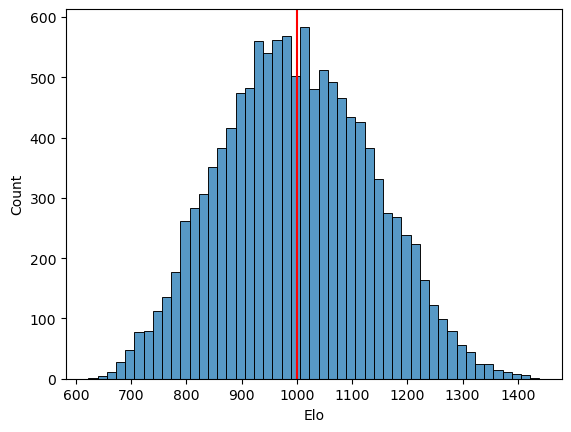

In [11]:
def update_elo_scores(df, scores_dict, k=40):
    for index, row in df.iterrows():
        player1, player2 = str(row['WTeamID']), str(row['LTeamID'])
        if player1 not in scores_dict:
            scores_dict[player1] = 1000
        if player2 not in scores_dict:
            scores_dict[player2] = 1000
        score1, score2 = scores_dict[player1], scores_dict[player2]
        expected_score1 = 1 / (1 + 10 ** ((score2 - score1) / 400))
        expected_score2 = 1 / (1 + 10 ** ((score1 - score2) / 400))
        scores_dict[player1] = score1 + k * (1 - expected_score1)
        scores_dict[player2] = score2 + k * (0 - expected_score2)
    return scores_dict

all_seasons = dict()
scores_dict = dict()

for season in range(2003, 2024):
    df_season_condensed_year = df_season_condensed[df_season_condensed['Season'] == season]
    scores_dict = update_elo_scores(df_season_condensed_year, scores_dict)
    all_seasons[str(season)] = scores_dict
    scores_dict = dict() # Reset dict for next season
    
elo_scores = pd.DataFrame(all_seasons)
elo_scores_unstacked = elo_scores.unstack().reset_index()
elo_scores_unstacked.columns = ['Season', 'TeamID', 'Elo']

elo_scores_unstacked = elo_scores_unstacked.astype({'Season':'int','TeamID':'int'})

sns.histplot(elo_scores_unstacked['Elo'])
plt.axvline(1000, color='red')
plt.show()

# Finalize dataframe with all features for a given season / team

In [12]:
df_features_season = df_features_season.merge(season_sabermetrics, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(elo_scores_unstacked, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(total_points[['Season','TeamID','Pythagorean']], on=['Season', 'TeamID'], how='left')

df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses','AvgWinningScoreMargin','AvgLosingScoreMargin','AvgScoringMargin'], axis=1, inplace=True)

df_features_season

,Season,TeamID,WinRatio,GapAvg,PtsPerPoss,EffectiveFGPct,AssistRate,ReboundPct,TORate,BArcPct,FTRate,FTPct,StealBlockFoul,Elo,Pythagorean
0,2003,1102,0.428571,0.250000,1.049026,0.584407,0.665276,0.919079,0.207292,0.518525,0.446693,0.642402,0.637119,961.260660,0.508752
1,2003,1103,0.481481,0.629630,1.119851,0.536564,0.560276,1.038184,0.181540,0.288910,0.465135,0.735271,0.675472,992.856082,0.516044
2,2003,1104,0.607143,4.285714,1.045276,0.475785,0.504413,1.177763,0.201266,0.346570,0.372350,0.705168,0.750342,1066.352822,0.624997
3,2003,1105,0.269231,-4.884615,0.939422,0.457983,0.593128,1.162163,0.243300,0.338957,0.359501,0.709598,0.719071,798.828208,0.371275
4,2003,1106,0.464286,-0.142857,0.944691,0.481697,0.496643,1.159560,0.253060,0.322344,0.307563,0.623158,0.768933,917.590482,0.495513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12130,2023,3473,0.040000,-17.400000,0.788499,0.457581,0.586598,0.816234,0.279164,0.415692,0.266616,0.691029,0.707648,719.577484,0.098710
12131,2023,3474,0.192308,-14.615385,0.784469,0.385667,0.319256,0.987848,0.205943,0.288116,0.321314,0.669925,0.650431,793.034327,0.139102
12132,2023,3475,0.346154,-3.461538,0.839228,0.435186,0.601020,0.979644,0.266648,0.282657,0.344825,0.778507,0.720482,879.687734,0.393644
12133,2023,3476,0.285714,-6.250000,0.875758,0.441719,0.644797,0.950476,0.212834,0.361112,0.247893,0.727435,0.682767,839.684308,0.309342


**Data Section 1 file: MNCAATourneyCompactResults.csv and WNCAATourneyCompactResults.csv**

These files identify the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the corresponding RegularSeasonCompactResults data. All men's games will show up as neutral site (so WLoc is always N) and some women's games will show up as neutral site, depending on the specifics. Note that this tournament game data also includes the play-in games for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

Because of the consistent structure of the NCAA® tournament schedule, you can generally tell what round a game was, depending on the exact DayNum. However, the men's 2021 tournament scheduling was slightly different, and the women's scheduling has varied a lot. Nevertheless, in general the men's schedule will be:

**DayNum=134 or 135 (Tue/Wed)** - play-in games to get the tournament field down to the final 64 teams

**DayNum=136 or 137 (Thu/Fri)** - Round 1, to bring the tournament field from 64 teams to 32 teams

**DayNum=138 or 139 (Sat/Sun)** - Round 2, to bring the tournament field from 32 teams to 16 teams

**DayNum=143 or 144 (Thu/Fri)** - Round 3, otherwise known as "Sweet Sixteen", to bring the tournament field from 16 teams to 8 teams

**DayNum=145 or 146 (Sat/Sun)** - Round 4, otherwise known as "Elite Eight" or "regional finals", to bring the tournament field from 8 teams to 4 teams

**DayNum=152 (Sat)** - Round 5, otherwise known as "Final Four" or "national semifinals", to bring the tournament field from 4 teams to 2 teams

**DayNum=154 (Mon)** - Round 6, otherwise known as "national final" or "national championship", to bring the tournament field from 2 teams to 1 champion team

In [13]:
df_tourney_results = pd.concat([
    pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/WNCAATourneyCompactResults.csv"),
    pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
3895,2022,146,1242,76,1274,50
3896,2022,146,1314,69,1389,49
3897,2022,152,1242,81,1437,65
3898,2022,152,1314,81,1181,77


In [14]:
# Make a dataframe which counts the teams NCAA wins over the last 4 years
df_test = df_tourney_results.copy()

# NCAA wins last year
NCAA_wins_1y = df_test.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins1", "WTeamID": "TeamID"})
NCAA_wins_1y['Season'] +=1
NCAA_wins_1y= NCAA_wins_1y[(NCAA_wins_1y['Season'] >= 2010)&(NCAA_wins_1y['Season'] <= 2023)]

# NCAA wins two years ago
NCAA_wins_2y = df_test.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins2", "WTeamID": "TeamID"})
NCAA_wins_2y['Season'] +=2
NCAA_wins_2y= NCAA_wins_2y[(NCAA_wins_2y['Season'] >= 2010)&(NCAA_wins_2y['Season'] <= 2023)]

# NCAA wins three years ago
NCAA_wins_3y = df_test.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins3", "WTeamID": "TeamID"})
NCAA_wins_3y['Season'] +=3
NCAA_wins_3y= NCAA_wins_3y[(NCAA_wins_3y['Season'] >= 2010)&(NCAA_wins_3y['Season'] <= 2023)]

# NCAA wins three years ago
NCAA_wins_4y = df_test.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins4", "WTeamID": "TeamID"})
NCAA_wins_4y['Season'] +=4
NCAA_wins_4y= NCAA_wins_4y[(NCAA_wins_4y['Season'] >= 2010)&(NCAA_wins_4y['Season'] <= 2023)]

# Merge all NCAA win dfs together 
NCAAwins1 = NCAA_wins_1y.groupby(['Season', 'TeamID']).count().reset_index()[['Season', 'TeamID']].rename(columns={"WTeamID": "TeamID"})
NCAAwins2 = NCAA_wins_2y.groupby(['Season', 'TeamID']).count().reset_index()[['Season', 'TeamID']].rename(columns={"LTeamID": "TeamID"})
NCAAwins3 = NCAA_wins_3y.groupby(['Season', 'TeamID']).count().reset_index()[['Season', 'TeamID']].rename(columns={"LTeamID": "TeamID"})
NCAAwins4 = NCAA_wins_4y.groupby(['Season', 'TeamID']).count().reset_index()[['Season', 'TeamID']].rename(columns={"LTeamID": "TeamID"})

NCAAwins  = pd.concat([NCAAwins1, NCAAwins2, NCAAwins3, NCAAwins4], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

NCAAwins = NCAAwins.merge(NCAA_wins_1y, on=['Season', 'TeamID'], how='left')
NCAAwins = NCAAwins.merge(NCAA_wins_2y, on=['Season', 'TeamID'], how='left')
NCAAwins = NCAAwins.merge(NCAA_wins_3y, on=['Season', 'TeamID'], how='left')
NCAAwins = NCAAwins.merge(NCAA_wins_4y, on=['Season', 'TeamID'], how='left')


NCAAwins['NCAA_wins'] = NCAAwins.NumWins1 + NCAAwins.NumWins2 + NCAAwins.NumWins3 + NCAAwins.NumWins4


NCAAwins.drop(['NumWins1', 'NumWins2','NumWins3', 'NumWins4'], axis=1, inplace=True)
NCAAwins.fillna(0, inplace=True)

NCAAwins

,Season,TeamID,NCAA_wins
0,2010,1104,0.0
1,2010,1112,0.0
2,2010,1113,0.0
3,2010,1116,0.0
4,2010,1130,0.0
...,...,...,...
1875,2023,3428,0.0
1876,2023,3437,0.0
1877,2023,3439,0.0
1878,2023,3452,0.0


# Construct training dataframe from previous tournament resusts

In [15]:
# Keep only data on or after 2012
df = df_tourney_results.copy()
df = df[df['Season'] >= 2010].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2010,138,3124,69,3201,55
1,2010,138,3173,67,3395,66
2,2010,138,3181,72,3214,37
3,2010,138,3199,75,3256,61
4,2010,138,3207,62,3265,42


In [16]:
# Add winning and losing Seeds to df
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2010,138,3124,69,3201,55,X04,X13
1,2010,138,3173,67,3395,66,X08,X09
2,2010,138,3181,72,3214,37,X02,X15
3,2010,138,3199,75,3256,61,W03,W14
4,2010,138,3207,62,3265,42,X05,X12


In [17]:
# Fix seed format
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2010,138,3124,69,3201,55,4,13
1,2010,138,3173,67,3395,66,8,9
2,2010,138,3181,72,3214,37,2,15
3,2010,138,3199,75,3256,61,3,14
4,2010,138,3207,62,3265,42,5,12
...,...,...,...,...,...,...,...,...
1555,2022,146,1242,76,1274,50,1,10
1556,2022,146,1314,69,1389,49,8,15
1557,2022,152,1242,81,1437,65,1,2
1558,2022,152,1314,81,1181,77,8,2


In [18]:
# Include features extracted from regular season results

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'PtsPerPoss': 'PtsPerPossW',
    'EffectiveFGPct': 'EffectiveFGPctW',
    'AssistRate': 'AssistRateW',
    'ReboundPct': 'ReboundPctW',
    'TORate': 'TORateW',
    'BArcPct': 'BArcPctW',
    'FTRate': 'FTRateW',
    'FTPct': 'FTPctW',
    'StealBlockFoul': 'StealBlockFoulW',
    'Elo': 'EloW',
    'Pythagorean': 'PythagoreanW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'PtsPerPoss': 'PtsPerPossL',
    'EffectiveFGPct': 'EffectiveFGPctL',
    'AssistRate': 'AssistRateL',
    'ReboundPct': 'ReboundPctL',
    'TORate': 'TORateL',
    'BArcPct': 'BArcPctL',
    'FTRate': 'FTRateL',
    'FTPct': 'FTPctL',
    'StealBlockFoul': 'StealBlockFoulL',
    'Elo': 'EloL',
    'Pythagorean': 'PythagoreanL',
}).drop(columns='TeamID', axis=1)

df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,...,EffectiveFGPctL,AssistRateL,ReboundPctL,TORateL,BArcPctL,FTRateL,FTPctL,StealBlockFoulL,EloL,PythagoreanL
0,2010,138,3124,69,3201,55,4,13,0.718750,15.250000,...,0.492357,0.558523,1.158103,0.219619,0.405237,0.302050,0.705732,0.902213,1243.879772,0.823781
1,2010,138,3173,67,3395,66,8,9,0.807692,11.269231,...,0.470597,0.607789,1.048044,0.220764,0.311178,0.297603,0.754030,0.913235,1155.049201,0.810296
2,2010,138,3181,72,3214,37,2,15,0.843750,16.531250,...,0.412575,0.520172,1.246350,0.224611,0.270408,0.321291,0.717344,0.793697,1115.272016,0.739977
3,2010,138,3199,75,3256,61,3,14,0.833333,14.366667,...,0.466902,0.533801,1.126204,0.226705,0.197541,0.377500,0.686634,0.834577,1182.399232,0.759344
4,2010,138,3207,62,3265,42,5,12,0.800000,9.666667,...,0.478543,0.617837,0.973989,0.201468,0.341630,0.336385,0.813747,0.950098,1186.769428,0.786915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2022,146,1242,76,1274,50,1,10,0.823529,10.441176,...,0.542989,0.503313,0.921886,0.137182,0.359034,0.293557,0.720431,0.890071,1148.733495,0.602438
1556,2022,146,1314,69,1389,49,8,15,0.727273,5.787879,...,0.479555,0.517576,1.057750,0.192671,0.304560,0.377842,0.687427,0.766295,1120.211866,0.620094
1557,2022,152,1242,81,1437,65,1,2,0.823529,10.441176,...,0.524635,0.485381,0.971134,0.144864,0.459048,0.312932,0.812341,0.747519,1288.022252,0.755306
1558,2022,152,1314,81,1181,77,8,2,0.727273,5.787879,...,0.556979,0.561422,0.989918,0.144227,0.366072,0.292483,0.728984,0.946346,1239.439685,0.805144


In [19]:
# Include features extracted from previous NCAA results

df = pd.merge(
    df,
    NCAAwins,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NCAA_wins': 'NCAA_winsW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    NCAAwins,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NCAA_wins': 'NCAA_winsL',
}).drop(columns='TeamID', axis=1)

df.fillna(0, inplace=True)


df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,...,ReboundPctL,TORateL,BArcPctL,FTRateL,FTPctL,StealBlockFoulL,EloL,PythagoreanL,NCAA_winsW,NCAA_winsL
0,2010,138,3124,69,3201,55,4,13,0.718750,15.250000,...,1.158103,0.219619,0.405237,0.302050,0.705732,0.902213,1243.879772,0.823781,6.0,0.0
1,2010,138,3173,67,3395,66,8,9,0.807692,11.269231,...,1.048044,0.220764,0.311178,0.297603,0.754030,0.913235,1155.049201,0.810296,0.0,0.0
2,2010,138,3181,72,3214,37,2,15,0.843750,16.531250,...,1.246350,0.224611,0.270408,0.321291,0.717344,0.793697,1115.272016,0.739977,10.0,0.0
3,2010,138,3199,75,3256,61,3,14,0.833333,14.366667,...,1.126204,0.226705,0.197541,0.377500,0.686634,0.834577,1182.399232,0.759344,5.0,0.0
4,2010,138,3207,62,3265,42,5,12,0.800000,9.666667,...,0.973989,0.201468,0.341630,0.336385,0.813747,0.950098,1186.769428,0.786915,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2022,146,1242,76,1274,50,1,10,0.823529,10.441176,...,0.921886,0.137182,0.359034,0.293557,0.720431,0.890071,1148.733495,0.602438,0.0,0.0
1556,2022,146,1314,69,1389,49,8,15,0.727273,5.787879,...,1.057750,0.192671,0.304560,0.377842,0.687427,0.766295,1120.211866,0.620094,0.0,0.0
1557,2022,152,1242,81,1437,65,1,2,0.823529,10.441176,...,0.971134,0.144864,0.459048,0.312932,0.812341,0.747519,1288.022252,0.755306,0.0,0.0
1558,2022,152,1314,81,1181,77,8,2,0.727273,5.787879,...,0.989918,0.144227,0.366072,0.292483,0.728984,0.946346,1239.439685,0.805144,0.0,0.0


In [20]:
# For each games create two entries so that both team get labeled Team A once and Team B once
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

df = add_loosing_matches(df)
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,...,ReboundPctB,TORateB,BArcPctB,FTRateB,FTPctB,StealBlockFoulB,EloB,PythagoreanB,NCAA_winsA,NCAA_winsB
0,2010,138,3124,69,3201,55,4,13,0.718750,15.250000,...,1.158103,0.219619,0.405237,0.302050,0.705732,0.902213,1243.879772,0.823781,6.0,0.0
1,2010,138,3173,67,3395,66,8,9,0.807692,11.269231,...,1.048044,0.220764,0.311178,0.297603,0.754030,0.913235,1155.049201,0.810296,0.0,0.0
2,2010,138,3181,72,3214,37,2,15,0.843750,16.531250,...,1.246350,0.224611,0.270408,0.321291,0.717344,0.793697,1115.272016,0.739977,10.0,0.0
3,2010,138,3199,75,3256,61,3,14,0.833333,14.366667,...,1.126204,0.226705,0.197541,0.377500,0.686634,0.834577,1182.399232,0.759344,5.0,0.0
4,2010,138,3207,62,3265,42,5,12,0.800000,9.666667,...,0.973989,0.201468,0.341630,0.336385,0.813747,0.950098,1186.769428,0.786915,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,...,1.010491,0.171226,0.338445,0.335013,0.723683,0.816627,1286.124723,0.757759,0.0,0.0
1556,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,...,1.064027,0.159191,0.373807,0.300486,0.767779,0.806647,1190.486586,0.650405,0.0,0.0
1557,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,...,1.010491,0.171226,0.338445,0.335013,0.723683,0.816627,1286.124723,0.757759,0.0,0.0
1558,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,...,1.064027,0.159191,0.373807,0.300486,0.767779,0.806647,1190.486586,0.650405,0.0,0.0


In [21]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', 'PtsPerPoss','EffectiveFGPct','AssistRate', 'ReboundPct', 'TORate', 'BArcPct', 'FTRate','FTPct', 'StealBlockFoul','Elo','Pythagorean','NCAA_wins'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']
    

In [22]:
# Add column for W/M tournament
df['W/M']= (df.TeamIdA > 3000)*1.0

In [23]:
# Compute Difference in Final Score (ScoreDiff) and whether or not the team won (WinA)
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,...,BArcPctDiff,FTRateDiff,FTPctDiff,StealBlockFoulDiff,EloDiff,PythagoreanDiff,NCAA_winsDiff,W/M,ScoreDiff,WinA
0,2010,138,3124,69,3201,55,4,13,0.718750,15.250000,...,-0.253755,0.136259,0.023243,0.132047,-60.322368,0.046256,6.0,1.0,14,1
1,2010,138,3173,67,3395,66,8,9,0.807692,11.269231,...,-0.026373,0.018284,-0.049986,-0.075754,33.399749,-0.010090,0.0,1.0,1,1
2,2010,138,3181,72,3214,37,2,15,0.843750,16.531250,...,-0.042786,0.000487,-0.054275,0.259424,184.811732,0.150956,10.0,1.0,35,1
3,2010,138,3199,75,3256,61,3,14,0.833333,14.366667,...,0.074451,-0.000460,0.028920,0.032094,71.032475,0.088106,5.0,1.0,14,1
4,2010,138,3207,62,3265,42,5,12,0.800000,9.666667,...,-0.007105,-0.008848,-0.083745,-0.001825,41.457122,-0.013793,0.0,1.0,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,...,0.020589,-0.041456,-0.003252,0.073443,-137.391228,-0.155321,0.0,0.0,-26,0
1556,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,...,-0.069247,0.077356,-0.080351,-0.040352,-70.274720,-0.030310,0.0,0.0,-20,0
1557,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,...,0.120602,-0.022081,0.088658,-0.069108,1.897529,-0.002453,0.0,0.0,-16,0
1558,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,...,-0.007735,-0.008003,-0.038795,0.139699,48.953099,0.154739,0.0,0.0,-4,0


# Create test datafile (for making submission file)

In [24]:
df_test = pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

df_test


,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476
130679,2023_3474_3477,0.5,2023,3474,3477
130680,2023_3475_3476,0.5,2023,3475,3476
130681,2023_3475_3477,0.5,2023,3475,3477


In [25]:
#Add seed info
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB
0,2023_1101_1102,0.5,2023,1101,1102,1,1
1,2023_1101_1103,0.5,2023,1101,1103,1,1
2,2023_1101_1104,0.5,2023,1101,1104,1,1
3,2023_1101_1105,0.5,2023,1101,1105,1,1
4,2023_1101_1106,0.5,2023,1101,1106,1,1
...,...,...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476,1,1
130679,2023_3474_3477,0.5,2023,3474,3477,1,1
130680,2023_3475_3476,0.5,2023,3475,3476,1,1
130681,2023_3475_3477,0.5,2023,3475,3477,1,1


In [26]:
# Add Season info
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
    'PtsPerPoss': 'PtsPerPossA',
    'EffectiveFGPct': 'EffectiveFGPctA',
    'AssistRate': 'AssistRateA',
    'ReboundPct': 'ReboundPctA',
    'TORate': 'TORateA',
    'BArcPct': 'BArcPctA',
    'FTRate': 'FTRateA',
    'FTPct': 'FTPctA',
    'StealBlockFoul': 'StealBlockFoulA',
    'Elo': 'EloA',
    'Pythagorean': 'PythagoreanA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
    'PtsPerPoss': 'PtsPerPossB',
    'EffectiveFGPct': 'EffectiveFGPctB',
    'AssistRate': 'AssistRateB',
    'ReboundPct': 'ReboundPctB',
    'TORate': 'TORateB',
    'BArcPct': 'BArcPctB',
    'FTRate': 'FTRateB',
    'FTPct': 'FTPctB',
    'StealBlockFoul': 'StealBlockFoulB',
    'Elo': 'EloB',
    'Pythagorean': 'PythagoreanB',
}).drop(columns='TeamID', axis=1)

In [27]:
# Include features extracted from previous NCAA results

df_test = pd.merge(
    df_test,
    NCAAwins,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NCAA_wins': 'NCAA_winsA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    NCAAwins,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NCAA_wins': 'NCAA_winsB',
}).drop(columns='TeamID', axis=1)

df_test.fillna(0, inplace=True)


df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,PtsPerPossA,...,ReboundPctB,TORateB,BArcPctB,FTRateB,FTPctB,StealBlockFoulB,EloB,PythagoreanB,NCAA_winsA,NCAA_winsB
0,2023_1101_1102,0.5,2023,1101,1102,1,1,0.346154,-3.692308,1.008457,...,0.910850,0.170464,0.450252,0.318029,0.716365,0.750594,938.275030,0.496269,0.0,0.0
1,2023_1101_1103,0.5,2023,1101,1103,1,1,0.346154,-3.692308,1.008457,...,1.005279,0.158474,0.438756,0.343952,0.744640,0.719465,1092.359629,0.658365,0.0,0.0
2,2023_1101_1104,0.5,2023,1101,1104,1,1,0.346154,-3.692308,1.008457,...,1.024899,0.181347,0.475374,0.378397,0.726025,0.750970,1301.621055,0.810963,0.0,0.0
3,2023_1101_1105,0.5,2023,1101,1105,1,1,0.346154,-3.692308,1.008457,...,0.956714,0.194210,0.329885,0.369262,0.645533,0.753943,911.123555,0.412642,0.0,0.0
4,2023_1101_1106,0.5,2023,1101,1106,1,1,0.346154,-3.692308,1.008457,...,0.980971,0.179985,0.333202,0.326752,0.693455,0.700288,762.713687,0.232862,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476,1,1,0.192308,-14.615385,0.784469,...,0.950476,0.212834,0.361112,0.247893,0.727435,0.682767,839.684308,0.309342,0.0,0.0
130679,2023_3474_3477,0.5,2023,3474,3477,1,1,0.192308,-14.615385,0.784469,...,1.009483,0.225784,0.243904,0.394590,0.672554,0.861792,924.253051,0.355218,0.0,0.0
130680,2023_3475_3476,0.5,2023,3475,3476,1,1,0.346154,-3.461538,0.839228,...,0.950476,0.212834,0.361112,0.247893,0.727435,0.682767,839.684308,0.309342,0.0,0.0
130681,2023_3475_3477,0.5,2023,3475,3477,1,1,0.346154,-3.461538,0.839228,...,1.009483,0.225784,0.243904,0.394590,0.672554,0.861792,924.253051,0.355218,0.0,0.0


In [28]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', 'PtsPerPoss','EffectiveFGPct','AssistRate', 'ReboundPct', 'TORate', 'BArcPct', 'FTRate','FTPct', 'StealBlockFoul','Elo','Pythagorean','NCAA_wins'
]

for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']
    

df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,PtsPerPossA,...,AssistRateDiff,ReboundPctDiff,TORateDiff,BArcPctDiff,FTRateDiff,FTPctDiff,StealBlockFoulDiff,EloDiff,PythagoreanDiff,NCAA_winsDiff
0,2023_1101_1102,0.5,2023,1101,1102,1,1,0.346154,-3.692308,1.008457,...,-0.065083,0.167625,-0.003529,-0.113198,0.011675,-0.009875,-0.098910,-27.039649,-0.096039,0.0
1,2023_1101_1103,0.5,2023,1101,1103,1,1,0.346154,-3.692308,1.008457,...,0.076563,0.073196,0.008461,-0.101702,-0.014247,-0.038151,-0.067782,-181.124248,-0.258136,0.0
2,2023_1101_1104,0.5,2023,1101,1104,1,1,0.346154,-3.692308,1.008457,...,0.044067,0.053576,-0.014412,-0.138321,-0.048692,-0.019535,-0.099286,-390.385675,-0.410734,0.0
3,2023_1101_1105,0.5,2023,1101,1105,1,1,0.346154,-3.692308,1.008457,...,0.090753,0.121761,-0.027274,0.007169,-0.039558,0.060957,-0.102259,0.111826,-0.012412,0.0
4,2023_1101_1106,0.5,2023,1101,1106,1,1,0.346154,-3.692308,1.008457,...,0.139938,0.097504,-0.013050,0.003852,0.002953,0.013035,-0.048605,148.521694,0.167367,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476,1,1,0.192308,-14.615385,0.784469,...,-0.325541,0.037372,-0.006891,-0.072996,0.073421,-0.057509,-0.032336,-46.649981,-0.170240,0.0
130679,2023_3474_3477,0.5,2023,3474,3477,1,1,0.192308,-14.615385,0.784469,...,-0.190721,-0.021634,-0.019841,0.044211,-0.073276,-0.002628,-0.211361,-131.218723,-0.216117,0.0
130680,2023_3475_3476,0.5,2023,3475,3476,1,1,0.346154,-3.461538,0.839228,...,-0.043777,0.029169,0.053814,-0.078455,0.096932,0.051072,0.037715,40.003426,0.084302,0.0
130681,2023_3475_3477,0.5,2023,3475,3477,1,1,0.346154,-3.461538,0.839228,...,0.091043,-0.029838,0.040864,0.038753,-0.049765,0.105953,-0.141310,-44.565317,0.038426,0.0


In [29]:
# Add column for W/M tournament
df_test['W/M']= (df_test.TeamIdA > 3000)*1.0

# Machine Learning

In [30]:
features = ['W/M','PtsPerPossDiff', 'EffectiveFGPctDiff','AssistRateDiff', 'ReboundPctDiff', 'TORateDiff', 'BArcPctDiff', 'FTRateDiff','FTPctDiff', 'StealBlockFoulDiff','EloDiff','PythagoreanDiff' , 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff','NCAA_winsDiff']

# Split data in features, X, and labels, y.
X = df[features]
y = df[['WinA']]

# Obtain test features
X_test = df_test[features]


## Optuna Hyperparam optimization

In [31]:
def objective(trial, X, y, cv, scoring):
  """
  An objective function to tune hyperparameters of Gradient Boosting Classifier.
  Args:
    trial: an Optuna trial
    X: DataFrame object, features
    y: Series object, Labels
    cv: k folds to cross-validate
    scoring: String, evaluation metric
  Return:
    Mean test brier score
  """
    

  params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step = 100),
    "learning_rate": trial.suggest_float("learning_rate", 1e-5, 3.0, log = True),
    "max_depth": trial.suggest_int("max_depth", 2, 9),
    "subsample": trial.suggest_float("subsample", 0.4, 1.0, step = 0.1),
    "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
    "random_state": 42,
    }

  # Perform cross validation
  clf = ensemble.GradientBoostingClassifier(**params)
  clf.fit(X, y)
    
  # Compute scores
  scores = cross_validate(clf, X, y, cv = cv, scoring = make_scorer(brier_score_loss), n_jobs = -1)
  brierscore = scores["test_score"].mean()

  return brierscore

In [32]:
from sklearn.model_selection import KFold, cross_validate

study = optuna.create_study(direction = "minimize")

kf = KFold(n_splits = 8, shuffle = True, random_state = 42)

func = lambda trial: objective(trial, X, y, cv = kf, scoring = make_scorer(brier_score_loss))

[I 2023-04-24 02:14:35,289] A new study created in memory with name: no-name-f6486ded-a1a6-4ca8-9c6c-7af4c398d6c0


In [ ]:
%%time
# Start optimizing with 50 trials
study.optimize(func, n_trials = 10)

In [ ]:
print(f"The best Brier Score reached by this study: {(study.best_value)}.")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")
    
best_params = study.best_params

In [ ]:
best_params

In [33]:
B_PARAMS = {'n_estimators': 2100,
 'learning_rate': 0.004589366903852494,
 'max_depth': 3,
 'subsample': 0.8,
 'max_features': 'log2'}

## Test performance of classifier with optimized hyperparameters on previous years

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2018  Brier score:  0.18670175357547758
2018 Logloss:  0.5482830960097707
AUROC: 0.7940


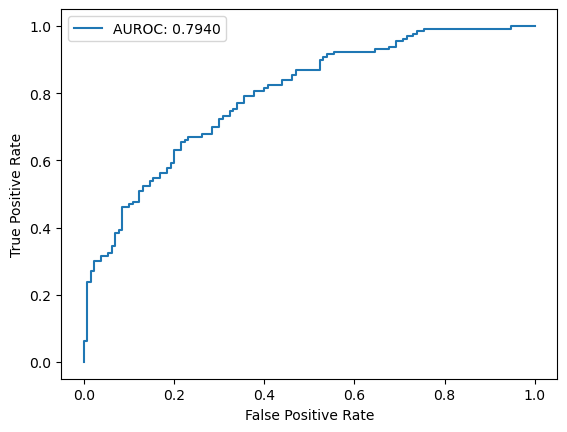

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2019  Brier score:  0.15785959620685844
2019 Logloss:  0.46878431201744164
AUROC: 0.8502


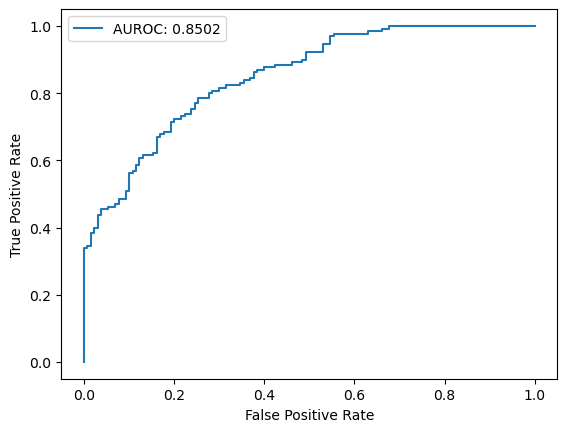

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2021  Brier score:  0.18084270610302386
2021 Logloss:  0.5364828660663361
AUROC: 0.8075


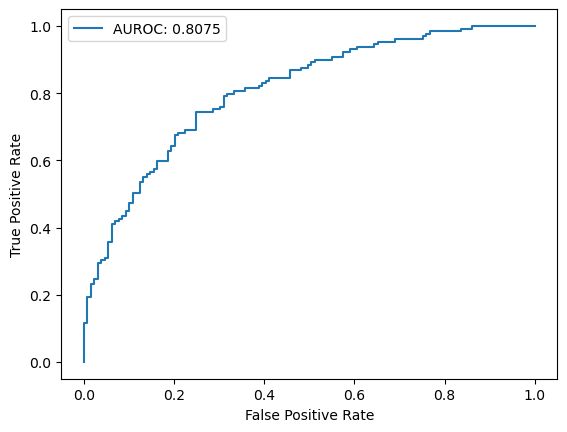

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2022  Brier score:  0.19222119339356913
2022 Logloss:  0.5689723903805761
AUROC: 0.7821


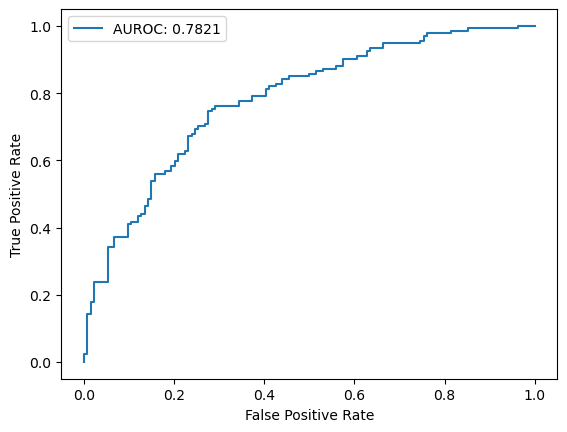

average Brier Score:  0.17940631231973225


In [34]:
# Select years you want to test the model on
briers = []
for year in [2018,2019,2021,2022]:
    
    df_testing = df

    # train on all seasons before 2021
    X_year = df_testing[df_testing['Season'] < year].reset_index(drop=True)[features]
    y_year = df_testing[df_testing['Season'] < year].reset_index(drop=True)[['WinA']]

    # test on 2021 results
    X_test_year = df_testing[df_testing['Season'] == year].reset_index(drop=True)[features]
    y_test_year = df_testing[df_testing['Season'] == year].reset_index(drop=True)[['WinA']]
    
    # Define Classifier
    model = ensemble.GradientBoostingClassifier(**B_PARAMS)

    # Fit Classifier
    model.fit(X_year, y_year)

    # Make predictions
    pred = model.predict_proba(X_test_year)[:, 1]

    # Evaluate performance

    # Print Brier Score
    score = ((y_test_year.to_numpy().flatten()- pred)**2).mean()
    print(year," Brier score: ", score)
    
    briers += [score]

    # Print Logloss
    print(year, "Logloss: ", sklearn.metrics.log_loss(y_test_year.to_numpy().flatten(), pred))

    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_year, pred)
    auc_test = sklearn.metrics.auc(fpr, tpr)
    print(f'AUROC: {auc_test:0.4f}')

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUROC: {auc_test:0.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
print("average Brier Score: ", np.mean(briers))

# Make Submission file

In [35]:
# Define Classifier
model = ensemble.GradientBoostingClassifier(**B_PARAMS)

# Fit Classifier
model.fit(X, y)

# Make predictions
pred = model.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
# Add predictions to submission file
df_test['pred'] = pred

final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [37]:
final_sub

,ID,pred
0,2023_1101_1102,0.457691
1,2023_1101_1103,0.322446
2,2023_1101_1104,0.278484
3,2023_1101_1105,0.466349
4,2023_1101_1106,0.537502
...,...,...
130678,2023_3474_3476,0.271962
130679,2023_3474_3477,0.317706
130680,2023_3475_3476,0.585960
130681,2023_3475_3477,0.377274


# Let's Gamble for the second submission

My gamble is not really a gamble. I bet that West Virginia will beat Maryland in one submission and the opposition in the other

In [38]:
df_gamble = final_sub

In [39]:
df_gamble['Season'] = df_gamble['ID'].apply(lambda x: int(x.split('_')[0]))
df_gamble['TeamIdA'] = df_gamble['ID'].apply(lambda x: int(x.split('_')[1]))
df_gamble['TeamIdB'] = df_gamble['ID'].apply(lambda x: int(x.split('_')[2]))

In [40]:
team_info = pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/MTeams.csv')
team_info


,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2023
1,1102,Air Force,1985,2023
2,1103,Akron,1985,2023
3,1104,Alabama,1985,2023
4,1105,Alabama A&M,2000,2023
...,...,...,...,...
372,1473,Lindenwood,2023,2023
373,1474,Queens NC,2023,2023
374,1475,Southern Indiana,2023,2023
375,1476,Stonehill,2023,2023


In [41]:
team_info[team_info.TeamName == 'urdue']

,TeamID,TeamName,FirstD1Season,LastD1Season


In [42]:
team_info[team_info.TeamName == 'F Dickinson']

,TeamID,TeamName,FirstD1Season,LastD1Season
91,1192,F Dickinson,1985,2023


In [43]:
df_gamble.loc[(df_gamble.TeamIdA == 1268)&(df_gamble.TeamIdB == 1452)]

,ID,pred,Season,TeamIdA,TeamIdB
45376,2023_1268_1452,0.605376,2023,1268,1452


In [44]:
df_gamble.loc[45376,'pred'] = 1

In [45]:
df_gamble.loc[45376,'pred'] 

1.0

In [46]:
gamble1 = df_gamble[['ID', 'pred']].copy()
gamble1.to_csv('submission1.csv', index=False)

In [47]:
df_gamble.loc[45376,'pred'] = 0

In [48]:
df_gamble.loc[45376,'pred'] 

0.0

In [49]:
gamble2 = df_gamble[['ID', 'pred']].copy()
gamble2.to_csv('submission2.csv', index=False)